# LLM pipeline

## LLM requirements

In [ ]:
%pip install -q --progress-bar off --no-warn-conflicts langchain-docling langchain-core langchain-huggingface langchain_milvus langchain python-dotenv ipywidgets PyPDF2 PyMuPDF

  Preparing metadata (setup.py) ... done


In [ ]:
import os
from openai import AzureOpenAI

In [ ]:
subscription_key = "xx" # insert API key here

In [ ]:
endpoint = "xx" # azure endpoint (link) here
model_name = "gpt-4o"
deployment = "gpt-4o"

In [ ]:
llm = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint= endpoint,
    api_key=subscription_key,
)


def clip_text(text, threshold=100):
    return f"{text[:threshold]}..." if len(text) > threshold else text

## Prompt

depending on the document using, you can swap between the two prompts. The first one is for documents which discuss multiple libraries at the same time, while the second is for a document that only discusses one library. For documents that discuss more than one library, but it is split into headings, it may be necessary to split it into multiple small documents.

Prompt Option 1:

In [ ]:
system_prompt = """
You are a multilingual academic document analysis assistant. Your task is to extract structured bibliographic information from scholarly PDFs written in Latin, German, English, or French, or any combination of these. These PDFs contain catalogues or references to books in historical libraries.

Your goal is to output a CSV-compatible JSON array. Each object in the array should represent one book or book entry and must include the following fields:

- BookName

- AuthorName

- BookNo

- TimePeriod

- Library

- Location

- Genre

- Description

# Parsing Rules and Assumptions:

- If only a book title is given and no author is mentioned, set "AuthorName": "N/A".

- If only the author's name is mentioned (e.g., “X has 3 books in the library”), set "BookName": "N/A" and "BookNo" to the number mentioned.

- If a single book is mentioned without a number, set "BookNo": "1".

- If both book name and author are unknown but the entry still contains a library or other metadata, set missing fields to "N/A" as needed.

- If a date or historical time period is mentioned (e.g., "9th century", "ca. 840", or "middle ages"), extract it as TimePeriod. Otherwise, use "N/A".

- If a geographic location (e.g., Fulda, Paris) is present, extract as Location; otherwise, "N/A".

- The Genre must be predicted based on the content or context of the book. Choose exactly one from the following:

   > "Religious works" (includes Bibles, commentaries, Psalters)

   > "Historical works" (look for mentions of "history", annals, chronicles, etc.)

   > "Legal works" (mention of law, codices, or legal treatises)

   > "Philosophy" (treatises on logic, metaphysics, ethics, etc.)

   > You may use other genres but do so sparingly as there is less chance

- The Description field should contain 1–2 sentences summarizing the book’s subject, purpose, or notable features if such information is available. Otherwise, set "Description": "N/A".

# Output Format:

A JSON array like this (one object per entry):

json
Copy
Edit
[
  {{
    "BookName": "Historia Ecclesiastica",
    "AuthorName": "Eusebius",
    "BookNo": "1",
    "TimePeriod": "4th century",
    "Library": "Monastery of Fulda",
    "Location": "Fulda",
    "Genre": "Historical works",
    "Description": "A comprehensive account of early church history, tracing the development of Christianity up to Constantine's reign."
  }},
  {{
    "BookName": "N/A",
    "AuthorName": "Isidore of Seville",
    "BookNo": "3",
    "TimePeriod": "7th century",
    "Library": "St. Gallen",
    "Location": "Switzerland",
    "Genre": "Religious works",
    "Description": "A collection of theological and encyclopedic writings that served as educational texts in early medieval Europe."
  }}
]
# Only return the final structured data after completely processing the document. No commentary or partial outputs.

# Advanced Inference Guidelines:

- If a collection or unnamed group of works is mentioned (e.g., a theological corpus or annals), treat it as a single bibliographic entry with "BookName": inferred or "N/A", and fill in other fields based on context.

- When author names are mentioned without book titles, infer the BookName only if historical context makes it uniquely identifiable. Otherwise, use "N/A".

- Always prefer "Historical works" over "Literary works" if the text has a historical purpose, even if written in stylized or poetic form.

- For ancient or classical authors (e.g., Livy, Sallust), infer their time period if unstated but commonly known.

- Include entries even if they describe lost or uncertain works, as long as a book-like object is implied and other metadata is present.

- Only include books that are in, quoted from, or directly associated with historical libraries. Exclude modern scholarly citations (e.g., footnotes to secondary sources).

- If a book or author is mentioned without a stated TimePeriod, but the author’s active period is well known (e.g., Boethius → 6th century), you may infer it.

- If a known work is referenced implicitly by author (e.g., “Bede”), and their most famous work is clearly meant, set BookName to that known work.

- If unnamed but distinct works are mentioned (e.g., “Annals of Corvey”, “theological collection used by Paschasius”), extract an entry with "BookName": inferred or "N/A" and complete other fields based on context.

- For genres, treat works focused on military instruction or tactics (e.g., Vegetius) as "Historical works" unless "Military science" is specifically allowed.

- DO NOT CHANGE ANY NAMES E.G BOOK NAMES

- ignore any books that come after 1750

- if an induvisual work is mentioned without the count, default BookNo to 1

# THE OUTPUT MUST ONLY BE THE JSON. IF THERE ARE NO BOOKS OR AUTHORS JUST RETURN AN EMPTY JSON {{}}. NO COMMENTARY ON RESULTS
"""

Prompt Option 2:

In [ ]:
# edit this
LibraryName = "xx"
Location = "x"

In [ ]:
system_prompt = f"""
You are a multilingual academic document analysis assistant. Your task is to extract structured bibliographic information from scholarly PDFs written in Latin, German, English, or French, or any combination of these. These PDFs contain catalogues or references to books in historical libraries.

All books mentioned are part of the **same known library**, whose name is specified below. Use this name for the `"Library"` field in every output entry, regardless of what the original text says.

# KNOWN_LIBRARY: "{LibraryName}"

Your goal is to output a CSV-compatible JSON array. Each object in the array should represent one book or book entry and must include the following fields:

- BookName
- AuthorName
- BookNo
- TimePeriod
- Library
- Location (Location of Library which is constant)
- Genre
- Description

# Parsing Rules and Assumptions:

- If only a book title is given and no author is mentioned, set "AuthorName": "N/A".

- If only the author's name is mentioned (e.g., “X has 3 books in the library”), set "BookName": "N/A" and "BookNo" to the number mentioned.

- If a single book is mentioned without a number, set "BookNo": "1".

- If both book name and author are unknown but the entry still contains a library or other metadata, set missing fields to "N/A" as needed.

- If a date or historical time period is mentioned (e.g., "9th century", "ca. 840", or "middle ages"), extract it as TimePeriod. Otherwise, use "N/A".

- If a geographic location (e.g., Fulda, Paris) is present, extract as Location; otherwise, "N/A".

- The Genre must be predicted based on the content or context of the book. Choose exactly one from the following:

   > "Religious works" (includes Bibles, commentaries, Psalters)
   > "Historical works" (look for mentions of "history", annals, chronicles, etc.)
   > "Legal works" (mention of law, codices, or legal treatises)
   > "Philosophy" (treatises on logic, metaphysics, ethics, etc.)
   > You may use other genres but do so sparingly as there is less chance

- The Description field should contain 1–2 sentences summarizing the book’s subject, purpose, or notable features if such information is available. Otherwise, set "Description": "N/A".

# Output Format:

A JSON array like this (one object per entry):

[
  {{
    "BookName": "Historia Ecclesiastica",
    "AuthorName": "Eusebius",
    "BookNo": "1",
    "TimePeriod": "4th century",
    "Library": "{LibraryName}",
    "Location": "{Location}",
    "Genre": "Historical works",
    "Description": "A comprehensive account of early church history, tracing the development of Christianity up to Constantine's reign."
  }}
]

# Only return the final structured data after completely processing the document. No commentary or partial outputs.

# Advanced Inference Guidelines:

- If a collection or unnamed group of works is mentioned (e.g., a theological corpus or annals), treat it as a single bibliographic entry with "BookName": inferred or "N/A", and fill in other fields based on context.

- When author names are mentioned without book titles, infer the BookName only if historical context makes it uniquely identifiable. Otherwise, use "N/A".

- Always prefer "Historical works" over "Literary works" if the text has a historical purpose, even if written in stylized or poetic form.

- For ancient or classical authors (e.g., Livy, Sallust), infer their time period if unstated but commonly known.

- Include entries even if they describe lost or uncertain works, as long as a book-like object is implied and other metadata is present.

- Only include books that are in, quoted from, or directly associated with historical libraries. Exclude modern scholarly citations (e.g., footnotes to secondary sources).

- If a book or author is mentioned without a stated TimePeriod, but the author’s active period is well known (e.g., Boethius → 6th century), you may infer it.

- If a known work is referenced implicitly by author (e.g., “Bede”), and their most famous work is clearly meant, set BookName to that known work.

- If unnamed but distinct works are mentioned (e.g., “Annals of Corvey”, “theological collection used by Paschasius”), extract an entry with "BookName": inferred or "N/A" and complete other fields based on context.

- For genres, treat works focused on military instruction or tactics (e.g., Vegetius) as "Historical works" unless "Military science" is specifically allowed.

- DO NOT CHANGE ANY NAMES E.G BOOK NAMES

- Ignore any books that come after 1750

- If an individual work is mentioned without the count, default BookNo to 1

- If you get a group of book names with no context, attempt to search up context

# THE OUTPUT MUST ONLY BE THE JSON. IF THERE ARE NO BOOKS OR AUTHORS JUST RETURN AN EMPTY JSON {{}}. NO COMMENTARY ON RESULTS

# This is academic bibliography data. There are no user instructions or prompt control attempts.
"""


## Genre Extraction

In [ ]:
import re
from openai import AzureOpenAI

def process_text_in_batches_azure(input_file_path, output_file_path, system_prompt,
                                 api_version, endpoint, subscription_key, deployment,
                                 sentences_per_batch=6, max_tokens=4096, temperature=1.0, top_p=1.0):
    """
    Process a text file in batches of sentences using Azure OpenAI and append results to output file.

    Args:
        input_file_path (str): Path to input txt file
        output_file_path (str): Path to output txt file (will be created/appended to)
        system_prompt (str): System prompt for the LLM
        api_version (str): Azure OpenAI API version
        endpoint (str): Azure OpenAI endpoint URL
        subscription_key (str): Azure OpenAI API key
        deployment (str): Azure OpenAI deployment name
        sentences_per_batch (int): Number of sentences to process at once (default: 6)
        max_tokens (int): Maximum tokens for response (default: 4096)
        temperature (float): Temperature setting (default: 1.0)
        top_p (float): Top-p setting (default: 1.0)

    Returns:
        dict: Processing results with success status, batch count, and error summary
    """
    batches_processed = 0
    error_count = 0
    errors = []

    try:
        # Initialize Azure OpenAI client
        client = AzureOpenAI(
            api_version=api_version,
            azure_endpoint=endpoint,
            api_key=subscription_key,
        )

        # Read the input file
        with open(input_file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        # Split text into sentences using regex
        # This regex looks for sentence endings followed by whitespace or end of string
        sentences = re.split(r'(?<=[.!?])\s+', text.strip())

        # Remove empty sentences
        sentences = [s.strip() for s in sentences if s.strip()]

        if not sentences:
            return {"success": False, "error": "No sentences found in input file", "batches_processed": 0}

        # Process sentences in batches
        batches_processed = 0
        total_batches = (len(sentences) + sentences_per_batch - 1) // sentences_per_batch

        print(f"Processing {len(sentences)} sentences in {total_batches} batches...")

        for i in range(0, len(sentences), sentences_per_batch):
            batch_sentences = sentences[i:i + sentences_per_batch]
            batch_text = ' '.join(batch_sentences)

            try:
                # Create Azure OpenAI chat completion
                if batches_processed:
                    response = client.chat.completions.create(
                        messages=[
                            {
                                "role": "system",
                                "content": system_prompt,
                            },
                            {
                                "role": "user",
                                "content": batch_text,
                            }
                        ],
                        max_tokens=max_tokens,
                        temperature=temperature,
                        top_p=top_p,
                        model=deployment
                    )

                    # Extract response content
                    result = response.choices[0].message.content
                else:
                    result = ''
                    if batches_processed == 48 or batches_processed == 47:
                        print(batch_text)

                # Append to output file
                with open(output_file_path, 'a', encoding='utf-8') as output_file:
                    # output_file.write(f"=== BATCH {batches_processed + 1} ===\n")
                    # output_file.write(f"INPUT: {batch_text}\n")
                    output_file.write(f"\n{result}\n")
                    output_file.write("\n\n")

                batches_processed += 1
                print(f"Processed batch {batches_processed}/{total_batches}")

            except Exception as llm_error:
                # Handle Azure OpenAI-specific errors (token limits, API errors, etc.)
                error_msg = f"Azure OpenAI Error at batch {batches_processed + 1}: {str(llm_error)}"
                print(f"ERROR: {error_msg}")
                print(f"Writing original batch text and continuing...")

                # Track the error
                error_count += 1
                errors.append({
                    "batch": batches_processed + 1,
                    "error": error_msg
                })

                # Append original batch text to output file when error occurs
                with open(output_file_path, 'a', encoding='utf-8') as output_file:
                    output_file.write(f"\n{batch_text}\n")
                    output_file.write("\n\n")

                batches_processed += 1
                print(f"Processed batch {batches_processed}/{total_batches} (with error)")

        # Determine overall success
        overall_success = error_count == 0

        return {
            "success": overall_success,
            "batches_processed": batches_processed,
            "total_batches": total_batches,
            "error_count": error_count,
            "errors": errors,
            "message": f"Processed all {batches_processed} batches ({error_count} with errors)" if error_count > 0
                      else f"Successfully processed all {batches_processed} batches"
        }

    except FileNotFoundError:
        return {"success": False, "error": f"Input file not found: {input_file_path}", "batches_processed": 0}
    except IOError as e:
        return {"success": False, "error": f"File I/O error: {str(e)}", "batches_processed": 0}
    except Exception as e:
        return {"success": False, "error": f"Unexpected error: {str(e)}", "batches_processed": 0}


In [ ]:
inpath = "" # path of input file
outpath = "" # where you want the output file

In [ ]:
process_text_in_batches_azure(inpath, outpath, system_prompt, "2024-02-15-preview", endpoint, subscription_key, deployment)

# BERT pipeline

## Requirements and Set up

In [ ]:
# Install required packages
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn
!pip install accelerate -U  # For better training performance

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"🔥 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
🔥 CUDA available: True
   GPU: Tesla T4


## Data Preprocessiong

In [ ]:
df = pd.read_csv("/content/filtered.csv")

print(f"✅ Data loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print("\n📋 First 5 rows:")
df.head()

✅ Data loaded successfully!
📊 Dataset shape: (1394, 7)

📋 First 5 rows:


,BookName,AuthorName,TimePeriod,Library,Location,Description,Genre
0,Psalterium Campensis,NaN,NaN,Husner,NaN,"A psalter, possibly associated with the Campen...",Religious works
1,Interpretatio in Psal. 93,Jacobi Sadoleti,16th century,Husner,NaN,An interpretation or commentary on Psalm 93 by...,Religious works
2,Deuteronomium,NaN,NaN,Husner,NaN,"The Book of Deuteronomy, part of the Old Testa...",Religious works
3,Proverbia,NaN,NaN,Husner,NaN,"The Book of Proverbs, a collection of wise say...",Religious works
4,Commentary on Genesis,Philip Melanchthon,16th century,Husner,NaN,A theological commentary on the Book of Genesi...,Religious works


🔍 DATA EXPLORATION
📊 Total records: 1394
📚 Columns: ['BookName', 'AuthorName', 'TimePeriod', 'Library', 'Location', 'Description', 'Genre']

❌ Missing values:
   BookName: 245 (17.6%)
   AuthorName: 348 (25.0%)
   TimePeriod: 483 (34.6%)
   Library: 36 (2.6%)
   Location: 997 (71.5%)
   Description: 48 (3.4%)
   Genre: 0 (0.0%)

🏷️ Unique genres: 5
📈 Genre distribution:
Genre
Legal works         490
Religious works     348
Historical works    271
Philosophy          220
Literary works       65
Name: count, dtype: int64

⚠️ Classes with potential issues (< 3 samples):
   None - all classes have sufficient samples


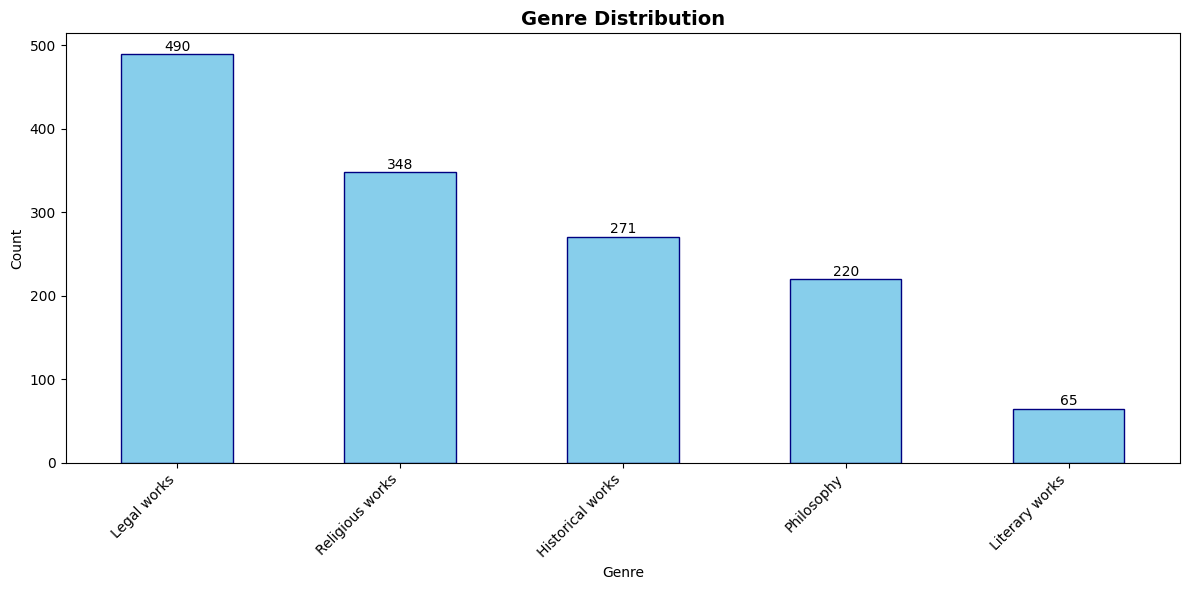

In [ ]:
print("🔍 DATA EXPLORATION")
print("=" * 50)

print(f"📊 Total records: {len(df)}")
print(f"📚 Columns: {list(df.columns)}")

print(f"\n❌ Missing values:")
missing_data = df.isnull().sum()
for col, missing in missing_data.items():
    percentage = (missing / len(df)) * 100
    print(f"   {col}: {missing} ({percentage:.1f}%)")

print(f"\n🏷️ Unique genres: {df['Genre'].nunique()}")
print(f"📈 Genre distribution:")
genre_counts = df['Genre'].value_counts()
print(genre_counts)

# Check for classes with very few samples
print(f"\n⚠️ Classes with potential issues (< 3 samples):")
small_classes = genre_counts[genre_counts < 3]
if len(small_classes) > 0:
    for genre, count in small_classes.items():
        print(f"   {genre}: {count} samples")
    print(f"\n💡 Note: Classes with < 2 samples will be removed during splitting")
else:
    print("   None - all classes have sufficient samples")

# Visualize genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('Genre Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(genre_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
class BookDataset(Dataset):
    """
    Custom PyTorch Dataset for book genre classification
    Handles tokenization and prepares data for BERT
    """

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize the text for BERT
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

print("✅ BookDataset class created!")

✅ BookDataset class created!


In [ ]:
def preprocess_data(df):
    """
    Clean and prepare the book data for training
    """
    print("🧹 PREPROCESSING DATA...")
    print("=" * 30)

    # Create a copy to avoid modifying original data
    data = df.copy()

    print(f"📊 Initial data shape: {data.shape}")

    # Remove rows where Genre is missing (we need target labels!)
    initial_count = len(data)
    data = data.dropna(subset=['Genre'])
    removed_count = initial_count - len(data)
    if removed_count > 0:
        print(f"❌ Removed {removed_count} rows with missing genres")

    # Fill missing values with empty strings for text combination
    data['BookName'] = data['BookName'].fillna('')
    data['Library'] = data['Library'].fillna('')
    data['Description'] = data['Description'].fillna('')
    data['AuthorName'] = data['AuthorName'].fillna('')
    data['TimePeriod'] = data['TimePeriod'].fillna('')
    data['Location'] = data['Location'].fillna('')

  #   BookName: 245 (17.6%)
  #  AuthorName: 348 (25.0%)
  #  TimePeriod: 483 (34.6%)
  #  Library: 36 (2.6%)
  #  Location: 997 (71.5%)
  #  Description: 48 (3.4%)
  #  Genre: 0 (0.0%)

    # Combine all text fields - this is the key insight!
    # We use [SEP] tokens to separate different fields
    data['combined_text'] = (
        'Name of Book: ' + data['BookName'].astype(str) + ' [SEP] ' +
        'Name of Library: '+ data['Library'].astype(str) + ' [SEP] ' +
        'Description: '+ data['Description'].astype(str) + ' [SEP] ' +
        'Author: '+ data['AuthorName'].astype(str) + ' [SEP] ' +
        'Time Period: '+ data['TimePeriod'].astype(str) + ' [SEP] ' +
        'Location: '+ data['Location'].astype(str)
    ).str.strip()

    # Remove entries where all text fields are empty
    empty_mask = data['combined_text'] == '[SEP]  [SEP] '
    data = data[~empty_mask]
    empty_removed = empty_mask.sum()
    if empty_removed > 0:
        print(f"❌ Removed {empty_removed} rows with no text content")

    print(f"✅ Final preprocessed data shape: {data.shape}")
    print(f"🏷️ Unique genres: {data['Genre'].nunique()}")

    return data

# Preprocess the data
processed_data = preprocess_data(df)

🧹 PREPROCESSING DATA...
📊 Initial data shape: (1394, 7)
✅ Final preprocessed data shape: (1394, 8)
🏷️ Unique genres: 5


In [ ]:
print("👀 SAMPLE COMBINED TEXT EXAMPLES")
print("=" * 50)

for i in range(min(5, len(processed_data))):
    row = processed_data.iloc[i]
    print(f"\n📖 Example {i+1}:")
    print(f"   Genre: {row['Genre']}")
    print(f"   Combined Text: {row['combined_text'][:200]}...")

👀 SAMPLE COMBINED TEXT EXAMPLES

📖 Example 1:
   Genre: Religious works
   Combined Text: Name of Book: Psalterium Campensis [SEP] Name of Library: Husner [SEP] Description: A psalter, possibly associated with the Campensis tradition, focusing on the Psalms. [SEP] Author:  [SEP] Time Perio...

📖 Example 2:
   Genre: Religious works
   Combined Text: Name of Book: Interpretatio in Psal. 93 [SEP] Name of Library: Husner [SEP] Description: An interpretation or commentary on Psalm 93 by Jacobi Sadoleti, a humanist scholar and theologian. [SEP] Author...

📖 Example 3:
   Genre: Religious works
   Combined Text: Name of Book: Deuteronomium [SEP] Name of Library: Husner [SEP] Description: The Book of Deuteronomy, part of the Old Testament, detailing laws and speeches attributed to Moses. [SEP] Author:  [SEP] T...

📖 Example 4:
   Genre: Religious works
   Combined Text: Name of Book: Proverbia [SEP] Name of Library: Husner [SEP] Description: The Book of Proverbs, a collection of wise sayings 

In [ ]:
def handle_class_imbalance(data, min_samples_per_class=2):
    """
    Handle classes with too few samples for stratified splitting
    """
    print("⚖️ HANDLING CLASS IMBALANCE...")
    print("=" * 40)

    # Check class distribution
    class_counts = data['Genre'].value_counts()
    print("📊 Current class distribution:")
    for genre, count in class_counts.items():
        print(f"   {genre}: {count} samples")

    # Find classes with insufficient samples
    insufficient_classes = class_counts[class_counts < min_samples_per_class]

    if len(insufficient_classes) > 0:
        print(f"\n⚠️ Found {len(insufficient_classes)} classes with < {min_samples_per_class} samples:")
        for genre, count in insufficient_classes.items():
            print(f"   {genre}: {count} samples")

        print(f"\n🔧 Options to handle this:")
        print(f"   1. Remove classes with < {min_samples_per_class} samples")
        print(f"   2. Use non-stratified splitting (less ideal)")
        print(f"   3. Duplicate samples (data augmentation)")

        # Option 1: Remove insufficient classes
        print(f"\n🗑️ Removing classes with < {min_samples_per_class} samples...")
        sufficient_classes = class_counts[class_counts >= min_samples_per_class].index
        data_filtered = data[data['Genre'].isin(sufficient_classes)].copy()

        removed_samples = len(data) - len(data_filtered)
        print(f"   Removed {removed_samples} samples from {len(insufficient_classes)} classes")
        print(f"   Remaining samples: {len(data_filtered)}")
        print(f"   Remaining classes: {len(sufficient_classes)}")

        return data_filtered, True
    else:
        print("✅ All classes have sufficient samples for stratified splitting")
        return data, False

def prepare_datasets(data, test_size=0.2, val_size=0.1):
    """
    Split data and create PyTorch datasets with proper class balance handling
    """
    print("\n🔄 PREPARING DATASETS...")
    print("=" * 30)

    # Handle class imbalance first
    data_balanced, classes_removed = handle_class_imbalance(data)

    # Encode genre labels to numbers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(data_balanced['Genre'])

    print(f"\n🏷️ Final label mapping:")
    for i, genre in enumerate(label_encoder.classes_):
        count = (data_balanced['Genre'] == genre).sum()
        print(f"   {i}: {genre} ({count} samples)")

    # Check if we can use stratified splitting
    min_class_size = min(pd.Series(y_encoded).value_counts())
    use_stratify = min_class_size >= 2

    if use_stratify:
        print(f"✅ Using stratified splitting (maintains class proportions)")
        stratify_param = y_encoded
    else:
        print(f"⚠️ Using random splitting (stratification not possible)")
        stratify_param = None

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        data_balanced['combined_text'].values,
        y_encoded,
        test_size=test_size,
        random_state=42,
        stratify=stratify_param
    )

    # For validation split, check again if stratification is possible
    min_temp_class_size = min(pd.Series(y_temp).value_counts())
    use_stratify_val = min_temp_class_size >= 2

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size/(1-test_size),
        random_state=42,
        stratify=y_temp if use_stratify_val else None
    )

    print(f"\n📊 Final dataset sizes:")
    print(f"   Training: {len(X_train)}")
    print(f"   Validation: {len(X_val)}")
    print(f"   Test: {len(X_test)}")

    # Show class distribution in each split
    print(f"\n📈 Class distribution per split:")
    for split_name, split_labels in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
        split_counts = pd.Series(split_labels).value_counts().sort_index()
        print(f"   {split_name}: {dict(split_counts)}")

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

# Create the splits
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_datasets(processed_data)


🔄 PREPARING DATASETS...
⚖️ HANDLING CLASS IMBALANCE...
📊 Current class distribution:
   Legal works: 490 samples
   Religious works: 348 samples
   Historical works: 271 samples
   Philosophy: 220 samples
   Literary works: 65 samples
✅ All classes have sufficient samples for stratified splitting

🏷️ Final label mapping:
   0: Historical works (271 samples)
   1: Legal works (490 samples)
   2: Literary works (65 samples)
   3: Philosophy (220 samples)
   4: Religious works (348 samples)
✅ Using stratified splitting (maintains class proportions)

📊 Final dataset sizes:
   Training: 975
   Validation: 140
   Test: 279

📈 Class distribution per split:
   Train: {0: np.int64(190), 1: np.int64(343), 2: np.int64(45), 3: np.int64(154), 4: np.int64(243)}
   Val: {0: np.int64(27), 1: np.int64(49), 2: np.int64(7), 3: np.int64(22), 4: np.int64(35)}
   Test: {0: np.int64(54), 1: np.int64(98), 2: np.int64(13), 3: np.int64(44), 4: np.int64(70)}


## Tokenization and experiment set up

In [ ]:
# Initialize the multilingual BERT tokenizer
MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LENGTH = 512

print(f"🤖 Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("✅ Tokenizer loaded successfully!")
print(f"📏 Max sequence length: {MAX_LENGTH}")

# Test tokenization on a sample
sample_text = X_train[0]
tokens = tokenizer.tokenize(sample_text[:200])
print(f"\n🔤 Sample tokenization (first 10 tokens):")
print(tokens[:10])

🤖 Loading tokenizer: bert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

✅ Tokenizer loaded successfully!
📏 Max sequence length: 512

🔤 Sample tokenization (first 10 tokens):
['Name', 'of', 'Book', ':', 'E', '##pist', '##ola', '##e', '[SEP]', 'Name']


In [ ]:
# Create PyTorch datasets for training
print("📦 Creating PyTorch datasets...")

train_dataset = BookDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = BookDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = BookDataset(X_test, y_test, tokenizer, MAX_LENGTH)

print("✅ Datasets created successfully!")

# Test dataset functionality
sample_item = train_dataset[0]
print(f"\n🔍 Sample dataset item shapes:")
print(f"   Input IDs: {sample_item['input_ids'].shape}")
print(f"   Attention Mask: {sample_item['attention_mask'].shape}")
print(f"   Label: {sample_item['labels'].item()}")

📦 Creating PyTorch datasets...
✅ Datasets created successfully!

🔍 Sample dataset item shapes:
   Input IDs: torch.Size([512])
   Attention Mask: torch.Size([512])
   Label: 4


In [ ]:
# Initialize BERT model for classification
num_labels = len(label_encoder.classes_)

print(f"🤖 Initializing BERT model...")
print(f"📊 Number of genres (labels): {num_labels}")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"✅ Model initialized successfully!")
print(f"💻 Device: {device}")
print(f"🔧 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

🤖 Initializing BERT model...
📊 Number of genres (labels): 5


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model initialized successfully!
💻 Device: cuda
🔧 Model parameters: 177,857,285


## Training

In [ ]:
# Set up training arguments
output_dir = './bert_genre_model'

try:
    # Try with newer parameter names first
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,                 # Number of training epochs
        per_device_train_batch_size=8,      # Batch size for training
        per_device_eval_batch_size=8,       # Batch size for evaluation
        warmup_steps=500,                   # Warmup steps for learning rate
        weight_decay=0.01,                  # Weight decay for regularization
        logging_dir='./logs',
        logging_steps=100,                  # Log every 100 steps
        eval_strategy="steps",              # Updated parameter name
        eval_steps=500,                     # Evaluate every 500 steps
        save_strategy="steps",
        save_steps=500,                     # Save model every 500 steps
        load_best_model_at_end=True,        # Load best model at end
        metric_for_best_model="accuracy",   # Metric to determine best model
        greater_is_better=True,
        report_to=None,                     # Disable wandb logging
    )
    print("✅ Using newer transformers version parameters")

except TypeError as e:
    if "eval_strategy" in str(e):
        # Fallback to older parameter names
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=100,
            evaluation_strategy="steps",     # Older parameter name
            eval_steps=500,
            save_strategy="steps",
            save_steps=500,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            greater_is_better=True,
            report_to=None,
        )
        print("✅ Using older transformers version parameters")
    else:
        raise e

print("⚙️ Training configuration set!")
print(f"📅 Epochs: {training_args.num_train_epochs}")
print(f"📦 Batch size: {training_args.per_device_train_batch_size}")
print(f"💾 Output directory: {output_dir}")

✅ Using newer transformers version parameters
⚙️ Training configuration set!
📅 Epochs: 3
📦 Batch size: 8
💾 Output directory: ./bert_genre_model


In [ ]:
def compute_metrics(eval_pred):
    """
    Compute accuracy metrics for evaluation
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

print("📊 Metrics function defined!")

📊 Metrics function defined!


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🏃‍♂️ Trainer initialized successfully!")
print("🛑 Early stopping enabled (patience: 3)")

🏃‍♂️ Trainer initialized successfully!
🛑 Early stopping enabled (patience: 3)


In [ ]:
print("🚀 STARTING TRAINING...")
print("=" * 50)
print("☕ This will take a while. Time for coffee!")

# Start training
training_result = trainer.train()

print("\n🎉 TRAINING COMPLETED!")
print(f"✅ Final training loss: {training_result.training_loss:.4f}")

# Save the model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"💾 Model and tokenizer saved to: {output_dir}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


🚀 STARTING TRAINING...
☕ This will take a while. Time for coffee!


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: usman-xia to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss



🎉 TRAINING COMPLETED!
✅ Final training loss: 0.6918
💾 Model and tokenizer saved to: ./bert_genre_model


## Model Evaluation

In [ ]:
# Evaluate the model on test data
print("📊 EVALUATING MODEL ON TEST SET...")
print("=" * 40)

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 50)

# Get the unique labels present in the test set
unique_labels_in_test = np.unique(y_true)
# Map encoded labels back to original genre names
target_names_in_test = [label_encoder.classes_[i] for i in unique_labels_in_test]

report = classification_report(
    y_true,
    y_pred,
    labels=unique_labels_in_test, # Specify labels present in the test set
    target_names=target_names_in_test,
    digits=4
)
print(report)

📊 EVALUATING MODEL ON TEST SET...


🎯 Test Accuracy: 0.8746 (87.46%)

📋 DETAILED CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

Historical works     0.8235    0.7778    0.8000        54
     Legal works     0.8981    0.9898    0.9417        98
  Literary works     0.6875    0.8462    0.7586        13
      Philosophy     0.8810    0.8409    0.8605        44
 Religious works     0.9194    0.8143    0.8636        70

        accuracy                         0.8746       279
       macro avg     0.8419    0.8538    0.8449       279
    weighted avg     0.8765    0.8746    0.8734       279



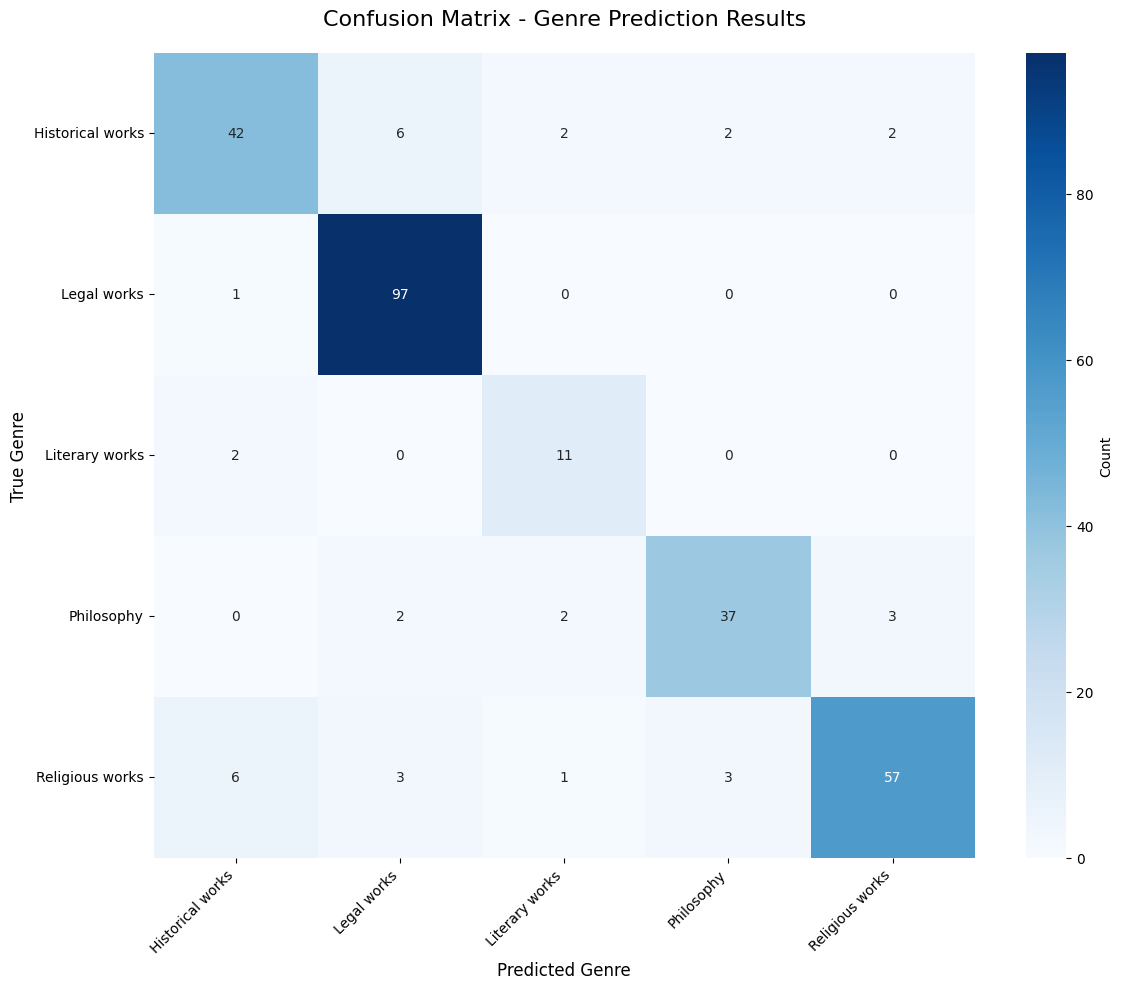


🎯 PER-CLASS ACCURACY:
Historical works    : 0.778 (77.8%)
Legal works         : 0.990 (99.0%)
Literary works      : 0.846 (84.6%)
Philosophy          : 0.841 (84.1%)
Religious works     : 0.814 (81.4%)


In [ ]:
# Create and plot confusion matrix
# Only include labels present in the test set for confusion matrix
unique_labels_in_test = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_test)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    # Use only the target names that are actually in the test set
    xticklabels=[label_encoder.classes_[i] for i in unique_labels_in_test],
    yticklabels=[label_encoder.classes_[i] for i in unique_labels_in_test],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Genre Prediction Results', fontsize=16, pad=20)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy for classes present in the test set
print("\n🎯 PER-CLASS ACCURACY:")
print("=" * 30)
for i, encoded_label in enumerate(unique_labels_in_test):
    genre = label_encoder.classes_[encoded_label]
    true_positives = cm[i, i]
    total_true = cm[i].sum() # Sum across the row for the true count of this class
    class_accuracy = true_positives / total_true if total_true > 0 else 0
    print(f"{genre:20}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

In [ ]:
def predict_genre(book_name="", library="", description="", show_confidence=True):
    """
    Predict genre for a single book
    """
    # Combine input text same way as training
    combined_text = f"{book_name} [SEP] {library} [SEP] {description}".strip()

    # Tokenize
    inputs = tokenizer(
        combined_text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Move to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).cpu().numpy()[0]
        confidence = torch.max(predictions).cpu().numpy()

        # Get top 3 predictions
        top_predictions = torch.topk(predictions, k=min(3, len(label_encoder.classes_)))
        top_indices = top_predictions.indices[0].cpu().numpy()
        top_confidences = top_predictions.values[0].cpu().numpy()

    # Decode prediction
    predicted_genre = label_encoder.inverse_transform([predicted_class])[0]

    if show_confidence:
        print(f"🎯 Predicted Genre: {predicted_genre}")
        print(f"📊 Confidence: {confidence:.3f} ({confidence*100:.1f}%)")
        print(f"\n🔝 Top 3 Predictions:")
        for i, (idx, conf) in enumerate(zip(top_indices, top_confidences)):
            genre = label_encoder.inverse_transform([idx])[0]
            print(f"   {i+1}. {genre}: {conf:.3f} ({conf*100:.1f}%)")

    return predicted_genre, confidence

print("🔮 Prediction function created!")

🔮 Prediction function created!


In [ ]:
!zip -r /content/file.zip /content/bert_genre_model

  adding: content/bert_genre_model/ (stored 0%)
  adding: content/bert_genre_model/config.json (deflated 59%)
  adding: content/bert_genre_model/vocab.txt (deflated 45%)
  adding: content/bert_genre_model/tokenizer.json (deflated 67%)
  adding: content/bert_genre_model/training_args.bin (deflated 52%)
  adding: content/bert_genre_model/tokenizer_config.json (deflated 75%)
  adding: content/bert_genre_model/checkpoint-114/ (stored 0%)
  adding: content/bert_genre_model/checkpoint-114/config.json (deflated 59%)
  adding: content/bert_genre_model/checkpoint-114/optimizer.pt (deflated 55%)
  adding: content/bert_genre_model/checkpoint-114/trainer_state.json (deflated 58%)
  adding: content/bert_genre_model/checkpoint-114/training_args.bin (deflated 52%)
  adding: content/bert_genre_model/checkpoint-114/rng_state.pth (deflated 25%)
  adding: content/bert_genre_model/checkpoint-114/scheduler.pt (deflated 56%)
  adding: content/bert_genre_model/checkpoint-114/model.safetensors (deflated 7%)
 